In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

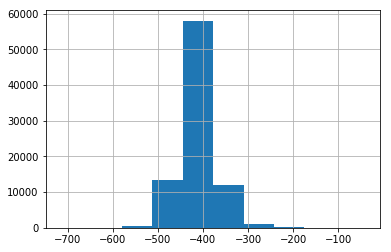

In [8]:
potential.potential_energy.hist()

In [9]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [10]:
# train['scalar_coupling_constant'].apply(int).value_counts()

In [11]:
y = train['scalar_coupling_constant']

In [ ]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [ ]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [ ]:
train = pd.concat([train, train_1], axis=1)
test = pd.concat([test, test_1], axis=1)


In [ ]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [ ]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [ ]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [ ]:
train_babel_feat = pd.read_csv('input/train_ob_charges.csv')
test_babel_feat = pd.read_csv('input/test_ob_charges.csv')


In [ ]:
train_babel_feat.shape

In [ ]:
train_babel_feat['atom_index_0'] = train_babel_feat.atom_index
train_babel_feat['atom_index_1'] = train_babel_feat.atom_index

test_babel_feat['atom_index_0'] = test_babel_feat.atom_index
test_babel_feat['atom_index_1'] = test_babel_feat.atom_index


In [ ]:
bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']

In [ ]:
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])

bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [ ]:

bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])


In [ ]:
bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [ ]:
train.head()

In [ ]:
train['q_0'] = train['eem_x'] * train['eem_y'] / train['dist'] ** 2
test['q_0'] = test['eem_x'] * test['eem_y'] / test['dist'] ** 2

train['q_1'] = train['qtpie_x'] * train['qtpie_y'] / train['dist'] ** 2
test['q_1'] = test['qtpie_x'] * test['qtpie_y'] / test['dist'] ** 2

In [ ]:
scaler.columns

In [ ]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [ ]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [ ]:
train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [39]:
y = y - train['fc'] 

In [40]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [41]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [42]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x    ...                 eem_y            qtpie_y  \
0  0.0019760   2.2   0.43    ...    -0.644530825087479 -3.093806799641671   
1  0.0019760   2.2   0.43    ...     0.161131811379221  0.773442481023162   
2  0.0019760   2.2   0.43    ...     0.161133990721081  0.773463412039650   
3  0.0019760   2.2   0.43    ...     0.161133663659230  0.773461556880489   
4  0.0002766   2.2   0.43    ...    -0.644530825087479 -3.093806799641671   

                 q_0                 q_1             dist_0        dist_1  \
0 -0.176076470226897  -4.056925318751444  1.527446181376614  0.0000158080   
1  0.834380601398988  19.224591655214667  2.511645603028724  0.0021758000   
2  0.834391886573259  19.225111913998976  2.502617066183318 -0.0011631500   
3  0.834390192965639  19.225065802389921  2.508472615109043  0.0017906512   
4 -0.176076964206423  -4.056941743505150  3.873287746897346  1.5899040000   

        dist_2             dist_3         m_0       d_0  
0 -0.006548580  0.000009513357272 -0.00654858  1.092030  
1 -0.008827920  0.000022639489243 -0.00654858  1.470030  
2 -0.008725410  0.000011824401403 -0.00654858  1.453030  
3 -0.008668125  0.000019418994832 -0.00654858  1.443530  
4 -0.012847340  0.566307184646745 -0.01284734  1.024695  

[5 rows x 132 columns]

In [43]:
train.shape

(4658147, 132)

In [47]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'seed': 666,
          'colsample_bytree': 1.0
         }

In [48]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [53]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 3000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        if all_pos:
            oof[train_index[valid_idx]] = np.expm1(clf.predict(x_train.iloc[valid_idx], 
                                                               num_iteration=clf.best_iteration))

            predictions[test_index] += np.expm1(clf.predict(test_[features],
                                                            num_iteration=clf.best_iteration)) / n_split

        else:
            oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

            predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0308638	valid_1's l1: 0.0348933
[1000]	training's l1: 0.0265535	valid_1's l1: 0.0333063
[1500]	training's l1: 0.0236428	valid_1's l1: 0.0325835
[2000]	training's l1: 0.021342	valid_1's l1: 0.032168
[2500]	training's l1: 0.0194252	valid_1's l1: 0.031906
[3000]	training's l1: 0.0177949	valid_1's l1: 0.0317272
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0177949	valid_1's l1: 0.0317272
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0309078	valid_1's l1: 0.0349512
[1000]	training's l1: 0.0265804	valid_1's l1: 0.0333098
[1500]	training's l1: 0.023648	valid_1's l1: 0.0325717
[2000]	training's l1: 0.0213528	valid_1's l1: 0.0321491
[2500]	training's l1: 0.0194605	valid_1's l1: 0.031886
[3000]	training's l1: 0.0178251	valid_1's l1: 0.0317041
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0178251	valid_1's l1:

[1000]	training's l1: 0.0057872	valid_1's l1: 0.00831305
[1500]	training's l1: 0.00485416	valid_1's l1: 0.00801252
[2000]	training's l1: 0.00418254	valid_1's l1: 0.00783622
[2500]	training's l1: 0.00366095	valid_1's l1: 0.00772043
[3000]	training's l1: 0.00324274	valid_1's l1: 0.00764273
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00324274	valid_1's l1: 0.00764273
Fold 4
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.00718917	valid_1's l1: 0.0089408
[1000]	training's l1: 0.00567695	valid_1's l1: 0.00830708
[1500]	training's l1: 0.00475129	valid_1's l1: 0.00802428
[2000]	training's l1: 0.00408281	valid_1's l1: 0.00785135
[2500]	training's l1: 0.00357152	valid_1's l1: 0.00774526
[3000]	training's l1: 0.0031656	valid_1's l1: 0.00766924
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0031656	valid_1's l1: 0.00766924
Fold 5
Training until validation scores don't improve for 50 rounds.
[500]	training's 

[1000]	training's l1: 0.00762672	valid_1's l1: 0.0100337
[1500]	training's l1: 0.00646944	valid_1's l1: 0.00951729
[2000]	training's l1: 0.00564009	valid_1's l1: 0.00919257
[2500]	training's l1: 0.00500397	valid_1's l1: 0.00898112
[3000]	training's l1: 0.0044955	valid_1's l1: 0.00882561
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0044955	valid_1's l1: 0.00882561
Fold 5
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.00961225	valid_1's l1: 0.0112184
[1000]	training's l1: 0.0076419	valid_1's l1: 0.0101022
[1500]	training's l1: 0.00647261	valid_1's l1: 0.00956738
[2000]	training's l1: 0.00563772	valid_1's l1: 0.00923494
[2500]	training's l1: 0.0050026	valid_1's l1: 0.00902091
[3000]	training's l1: 0.00448948	valid_1's l1: 0.00886302
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00448948	valid_1's l1: 0.00886302
Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1:

In [63]:
predictions

array([ 4.72732512,  0.46440551, -0.84268878, ..., -0.17531309,
       -0.04407976,  1.79162672])

In [64]:
predictions

array([ 4.72732512,  0.46440551, -0.84268878, ..., -0.17531309,
       -0.04407976,  1.79162672])

In [65]:
test.shape

(2505542, 128)

In [66]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [67]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [68]:
sub.shape

(2505542, 2)

In [69]:
len(predictions)

2505542

In [70]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.3.4.csv", index=False)

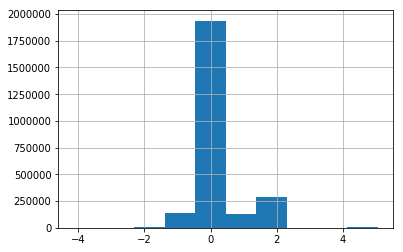

In [71]:
sub['scalar_coupling_constant'].hist()

In [72]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.3.1.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.3.1.csv', index=False)

In [63]:
np.log(1 + y_train.iloc[valid_idx].astype(int).map(y_train.iloc[train_idx].astype(int).value_counts().to_dict()).fillna(-33))

9          10.609452236806687
53          9.803335670585687
76          9.705341445395202
169        10.207694828570066
187        10.388964598613677
220        10.163001605159987
271         9.772125234339301
322         9.709417248707625
427         8.699181359308954
511        10.609452236806687
515        10.163001605159987
556        10.373459931293572
572         8.634798433490500
601         8.588769389905460
621        10.163001605159987
644        10.163001605159987
725         7.795234929002173
761         7.521859252201629
767         7.314552832324080
787        10.483689974079939
835        10.388964598613677
895        10.551323510386069
901        10.373459931293572
992        10.388964598613677
1009       10.609452236806687
1022       10.609452236806687
1095       10.551323510386069
1099       10.551323510386069
1104        8.513586695822125
1250       10.163001605159987
                  ...        
4656946     8.197263371414335
4656979     8.294549515143679
4657005   